# Homework: Goals & Approaches

> The body grows stronger under stress. The mind does not.
> 
>  -- Magic the Gathering, _Fractured Sanity_

This homework deals with the goals you must define, along with the approaches you deem necessary to achieve those goals. 
Key to this will be a focus on your _workflows_: 

- are they reproducible? 
- are they maintainable? 
- are they well-justified and communicated? 

This is not a "machine-learning" course, but machine learning plays a large part in modern text analysis and NLP. 
Machine learning, in-turn, has a number of issues tracking and solving issues in a collaborative, asynchronous, distributed manner. 

It's not inherently _wrong_ to use pre-configured models and libraries! 
In fact, you will likely be unable to create a set of ML algorithms that "beat" something others have spent 100's of hours creating, optimizing, and validating. 
However, to answer the three questions above, we need a way to explicitly track our decisions to use others' work, and efficiently _swap out_ that work for new ideas and directions as the need arises. 

This homework is a "part 1" of sorts, where you will construct several inter-related pipelines in a way that will allow _much easier_ adjustment, experimentation, and measurement in "part 2"

## Setup

### Dependencies 
As before, ensure you have an up-to-date environment to isolate your work. 
Use the `environment.yml` file in the project root to create/update the `text-data-class` environment. 
> I expect any additional dependencies to be added here, which will show up on your pull-request. 

### Data
Once again, we have set things up to use DVC to import our data. 
If the data changes, things will automatically update! 
The data for this homework has been imported as `mtg.feather` under the `data/` directory at the top-level of this repository. 
In order to ensure your local copy of the repo has the actual data (instead of just the `mtg.feather.dvc` stub-file), you need to run `dvc pull`

In [1]:
!dvc pull

Everything is up to date.


ERROR: failed to pull data from the cloud - unable to remove 'C:\Users\jeffw\text-data-spr22\homework\hw2-goals-approaches\jwoodham\multilabel_model.pkl' without a confirmation. Use `-f` to force.


Then you may load the data into your notebooks and scripts e.g. using pandas+pyarrow:

In [14]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
import nltk
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import json

In [87]:
df = (pd.read_feather('../../../data/mtg.feather')
     ).dropna(subset=['flavor_text'])

But that's not all --- at the end of this homework, we will be able to run a `dvc repro` command and all of our main models and results will be made available for your _notebook_ to open and display.

### Submission Structure
You will need to submit a pull-request on DagsHub with the following additions: 

- your subfolder, e.g. named with your user id, inside the `homework/hw2-goals-approaches/` folder
    - your "lab notebook", as an **`.ipynb` or `.md`** (e.g. jupytext), that will be exported to PDF for Canvas submission. **This communicates your _goals_**, along with the results that will be compared to them. 
    - your **`dvc.yaml`** file that will define  the inputs and outputs of your _approaches_. See [the DVC documentation](https://dvc.org/doc/user-guide/project-structure/pipelines-files) for information!
    - **source code** and **scripts** that define the preprocessing and prediction `Pipeline`'s you wish to create. You may then _print_ the content of those scripts at the end of your notebook e.g. as appendices using 
- any updates to `environment.yml` to add the dependencies you want to use for this homework

## Part 1: Unsupervised Exploration

Investigate the [BERTopic](https://maartengr.github.io/BERTopic/index.html) documentation (linked), and train a model using their library to create a topic model of the `flavor_text` data in the dataset above. 

- In a `topic_model.py`, load the data and train a bertopic model. You will `save` the model in that script as a new trained model object
- add a "topic-model" stage to your `dvc.yaml` that has `mtg.feather` and `topic_model.py` as dependencies, and your trained model as an output
- load the trained bertopic model into your notebook and display
    1. the `topic_visualization` interactive plot [see docs](https://maartengr.github.io/BERTopic/api/plotting/topics.html)
    2. Use the plot to come up with working "names" for each major topic, adjusting the _number_ of topics as necessary to make things more useful. 
    3. Once you have names, create a _Dynamic Topic Model_ by following [their documentation](https://maartengr.github.io/BERTopic/getting_started/topicsovertime/topicsovertime.html). Use the `release_date` column as timestamps. 
    4. Describe what you see, and any possible issues with the topic models BERTopic has created. **This is the hardest part... interpreting!**

In [62]:
# Import the topic model

topic_model = BERTopic.load('flavor_model')

In [63]:
# We need to recreate the probabilities and topics here, since they aren't saved with the model

probs = topic_model.hdbscan_model.probabilities_
topics = topic_model._map_predictions(topic_model.hdbscan_model.labels_)

In [64]:
# Visualize!

topic_model.visualize_topics()

In [65]:
# Let's reduce the number of topics to 7, since we see approximately 7 rough clusters.

flavor = df['flavor_text'].to_list()

new_topics, new_probs = topic_model.reduce_topics(flavor, topics, nr_topics=7)

topic_model.visualize_topics()

In [66]:
# Let's look at our new topics

topic_model.get_topic_info()

,Topic,Count,Name
0,-1,24900,-1_like_life_world_time
1,0,1022,0_kjeldor_coldeyes_lovisa_balduvian
2,1,887,1_wind_nature_sea_river
3,2,693,2_light_sun_darkness_dark
4,3,646,3_death_dead_life_die
5,4,528,4_sword_blade_weapon_steel
6,5,484,5_goblins_goblin_squee_dementia
7,6,475,6_prey_hunger_hunters_hunt


### Topics
1. Balduvia (https://mtg.fandom.com/wiki/Balduvia, https://mtg.fandom.com/wiki/LovisLiga_Coldeyes)
2. Maritime
3. Light/Dark
4. Mortality
5. Sword
6. Goblins
7. Predator/Prey

In [99]:
# Now we'll look at topics over time

timestamps = df.release_date.to_list()

topics_over_time = topic_model.topics_over_time(flavor, new_topics, timestamps)
topic_model.visualize_topics_over_time(topics_over_time, topics = [0, 1, 2, 3, 4, 5, 6])

If we look at topics over time it's a bit of a mess, though there are some jumps around 1995, and closer to 2020. There's a big jump around 1995 in the Balduvia topic, which corresponds with the release of the Ice Age set (https://mtg.fandom.com/wiki/Ice_Age). I assume that other similar spikes (though none happens over a broad a period of time) correspond with releases of themed sets. There also is a general rise in freuency of all themes after 2020. This may be related to an increase in sales and more cards being produced during the COVID-19 pandemic (https://wegotthiscovered.com/gaming/magic-gathering-revenues-significantly-2020-coronavirus-concerns/). This visualization looks at gross frequency though - what if we look at the relative importance of themes over time?

In [100]:
# Generate cards per release date

counts = pd.DataFrame(df.release_date.value_counts())
counts = counts.reset_index() 
counts.columns = ['Timestamp', 'Count']

In [101]:
# Merge with the topics_over_time dataframe and generate the frequency of a given topic relative to the number of cards released

topics_over_time = topics_over_time.merge(counts, on='Timestamp')
topics_over_time['Frequency'] = topics_over_time['Frequency'] / topics_over_time['Count']

In [102]:
# Visualize relative frequency of topics over time

topic_model.visualize_topics_over_time(topics_over_time, topics = [0, 1, 2, 3, 4, 5, 6])

Looking at relative importance of themes over time, we see some severe spikes (probably due to just a small number of cards released on a given day - it is unlikely that 100% of cards released in a set would be related to one topic. We still see the importance of Balduvia with the release of the Ice Age set in 1995, and a rise in the frequency of theme 5 (Goblins) in the past couple of years. In order to account for variance in how cards are released (with some dates only having one card releaesd and others having over 1,000), it may be useful to look at the importance of themes by month rather than by date of release. It's also interesting the topic 1 (Balduvia) seems to be the only one related to a specific fictional setting - I wonder if this is because BERTopic missed the others, other settings simply aren't as prominent, or if BERTopic combined them all within a fantasy setting topic (rather than a Balduvia topic).

## Part 2 Supervised Classification

Using only the `text` and `flavor_text` data, predict the color identity of cards: 

Follow the sklearn documentation covered in class on text data and Pipelines to create a classifier that predicts which of the colors a card is identified as. 
You will need to preprocess the target _`color_identity`_ labels depending on the task: 

- Source code for pipelines
    - in `multiclass.py`, again load data and train a Pipeline that preprocesses the data and trains a multiclass classifier (`LinearSVC`), and saves the model pickel output once trained. target labels with more than one color should be _unlabeled_! 
    - in `multilabel.py`, do the same, but with a multilabel model (e.g. [here](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multilabel.html#sphx-glr-auto-examples-miscellaneous-plot-multilabel-py)). You should now use the original `color_identity` data as-is, with special attention to the multi-color cards. 
- in `dvc.yaml`, add these as stages to take the data and scripts as input, with the trained/saved models as output. 

- in your notebook: 
    - Describe:  preprocessing steps (the tokenization done, the ngram_range, etc.), and why. 
    - load both models and plot the _confusion matrix_ for each model ([see here for the multilabel-specific version](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html))
    - Describe: what are the models succeeding at? Where are they struggling? How do you propose addressing these weaknesses next time?

In [105]:
# Load up the two models

mcobject = open('multiclass_model.pkl', 'rb')
mcmodel = pickle.load(mcobject)

mlobject = open('multilabel_model.pkl', 'rb')
mlmodel = pickle.load(mlobject)

### Pre-Processing
- Tokenize - using a regex expression that includes any set of characters that starts with a letter (following a word boundary) and is followed by one or more of a letter, apostrophe, or number, followed by a word boundary (so excluding punctuation besides contractions). This will get rid of punctuation and quotations marks (which there are many of) in the flavor text, as well as any mentions of mana costs and color, which I'm not interested in if I want to know how the narrative text reltaes to the classification. It will also exclude single-character words like "I" and "a", which don't add a lot (and will be removed by stopwords anyway). 

- N-gram - max n-gram is set to 2 to account for possible compound meanings (e.g. "draw sword", "Ice Age"). It may also help account for proper nouns/names, which I expect to be common in flavor text.

- Stop words - remove English stop words - I expect most of the relationship between flavor text and color to be based on nouns tied to a specific setting (e.g. snow, trees, ocean), so I'm not too worried about losing basic verbs, contractions, general pronouns, prepositions. 


### Multiclass Classification

In [106]:
# Prep our data - drop those with multiple color identities

df1 = (pd.read_feather('../../../data/mtg.feather', 
                      columns = ['name','text', 'color_identity','flavor_text', 'release_date']
                     )
                     ).dropna(subset=['color_identity', 'text', 'flavor_text'])

df1['color_identity'] = df1.color_identity.where(df1.color_identity.str.len() == 1, np.nan)

df1 = df1.dropna(subset=['color_identity'])

In [107]:
# Prepare true and predicted values

y_true = df1.color_identity.apply(lambda x: x[0])
y_pred = mcmodel.predict(df1['flavor_text'])

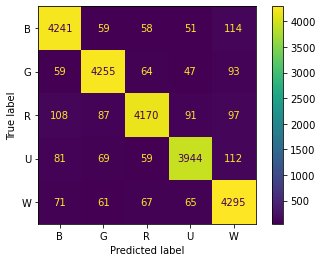

In [108]:
# Confusion matrix!

cm = confusion_matrix(y_true, y_pred, labels = mcmodel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = mcmodel.classes_)

disp.plot()
plt.show()

### Multilabel Classification

In [115]:
# Prepare data and prep true aand predicted values

df1 = (pd.read_feather('C:/Users/JeffW/text-data-spr22/data/mtg.feather', 
                      columns = ['name','text', 'color_identity','flavor_text', 'release_date']
                     )
                     ).dropna(subset=['color_identity', 'text', 'flavor_text'])

mlb = MultiLabelBinarizer()
y_true = mlb.fit_transform(df1['color_identity'])
y_pred = mlmodel.predict(df1['flavor_text'])

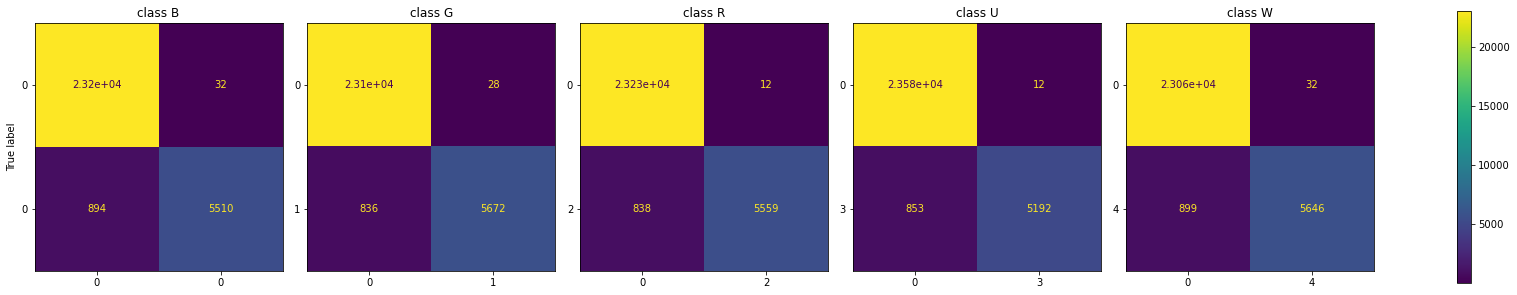

In [128]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

multilabel_confusion_matrix(y_true, y_pred)

f, axes = plt.subplots(1, 5, figsize=(30, 5))
axes = axes.ravel()
for i in range(len(mlmodel.classes_)):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {mlb.classes_[i]}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

## Part 3: Regression?

> Can we predict the EDHREC "rank" of the card using the data we have available? 

- Like above, add a script and dvc stage to create and train your model
- in the notebook, aside from your descriptions, plot the `predicted` vs. `actual` rank, with a 45-deg line showing what "perfect prediction" should look like. 
- This is a freeform part, so think about the big picture and keep track of your decisions: 
    - what model did you choose? Why? 
    - What data did you use from the original dataset? How did you proprocess it? 
    - Can we see the importance of those features? e.g. logistic weights? 
    
How did you do? What would you like to try if you had more time?

In [130]:
# Bring in regression model

regobject = open('regression.pkl', 'rb')
lasso= pickle.load(regobject)

In [133]:
# Bring in data and prep for use in model

df = (pd.read_feather('C:/Users/JeffW/text-data-spr22/data/mtg.feather', 
                      columns = ['name','text', 'color_identity', 'flavor_text','release_date', 'edhrec_rank']
                     )
                     ).dropna(subset=['name', 'text', 'color_identity', 'flavor_text', 'release_date', 'edhrec_rank'])

df['flavor_text'] = df['flavor_text'].str.replace(r"[()-.,!?@\'\`\"\_\n]", " ")
df['flavor_text'] = df['flavor_text'].str.lower()

tokenizer = RegexpTokenizer(r'\w+')

df['flavor'] = df['flavor_text'].apply(tokenizer.tokenize)

df['flavor'] = df['flavor_text'].str.split(',').str.join(' ')

X = df['flavor']
y_true = df['edhrec_rank']

In [140]:
# TF-IDF for Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=.3, random_state = 0)

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [141]:
# Ideally, I wouldn't be retraining the model here, but I'm having trouble with the dimensions.
# From what I can figure out, either I include the whole sample when I develop the model and then just run it through again here, or I retrain it here to see if the model is generalizable.

lasso.fit(X_train_tfidf, y_train)

Lasso(alpha=0.1)

In [143]:
# Predicted values for y

y_pred = lasso.predict(X_test_tfidf)

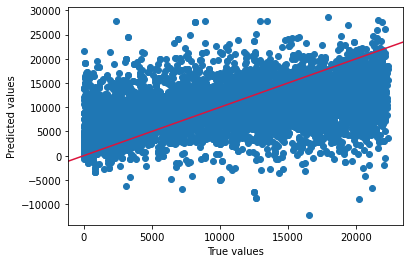

In [144]:
# Visualize! Predicted ranking over actual ranking based on flavor text.

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.scatter(y_test, y_pred)
plt.xlabel("True values")
plt.ylabel("Predicted values")
ax.axline((0,0), (max(y_test),max(y_test)), color='crimson')
plt.show()

## Part 4: Iteration, Measurement, & Validation

> No model is perfect, and experimentation is key. How can we more easily iterate and validate our model? 

- Pick **ONE** of your models above (regression, multilabel, or multiclass) that you want to improve or investigate, and calculate metrics of interest for them to go beyond our confusion matrix/predicted-actual plots: 
    - for multiclass, report average and F1
    - for multilabel, report an [appropriate metric](https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-ranking-metrics) (e.g. `ranking_loss`)
    - for regression, report an [appropriate metric](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) (e.g. 'MAPE' or MSE), **OR** since these are *ranks*, the [pearson correlation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) between predicted and actual may be more appropriate?
- in the corresponding `dvc.yaml` stage for your model-of-interest, add `params` and `metrics`
    - under `params`, pick a setting in your preprocessing (e.g. the `TfidfVecorizer`) that you want to change to imrpove your results. Set that param to your current setting, and have your model read from a `params.yaml` rather than directly writing it in your code. [^1]
    - under `metrics`, reference your `metrics.json` and have your code _write_ the results as json to that file, rather than simply printing them or reporting them in the notebook. 
- commit your changes to your branch, run `dvc repro dvc.yaml` for your file, then run a _new experiment_ that changes that one parameter: e.g. `dvc exp run -S preprocessing.ngrams.largest=1` (see the `example/` folder for a complete working example). 

Report the improvement/reduction in performance with the parameter change for your metric, whether by copy-pasting or using `!dvc exp diff` in the notebook, the results of `dvc exp diff`. 
    
[^1]: in production or bigger projects, consider using [`hydra`](https://hydra.cc/), [`driconfig`](https://dribia.github.io/driconfig/), or others like them to help manage .yaml and .toml settings files even better.

In [22]:
!dvc exp diff exp-6427a

Path          Metric     exp-6427a    workspace    Change
metrics.json  f1-score   0.76072      0.77695      0.016225
metrics.json  precision  0.76114      0.77798      0.016842
metrics.json  recall     0.76078      0.77698      0.016206

Path         Param                     exp-6427a    workspace    Change
params.yaml  preprocessing.ngrams.max  1            2            1


## Extra Credit (5 pts) 
If you can, use a feature importance or model explanation technique like LIME to describe, _briefly_, why your model is behaving in the way it is. E.g. what spots in the text for a green card are leading to it's classification as _green_, or what features are useful to say what the regressor thinks the EDHREC Rank should be.

In [16]:
import lime
from lime import lime_text

df = (pd.read_feather('../../../data/mtg.feather')
     ).dropna(subset=['flavor_text'])

In [30]:
mlobject = open('multilabel_model.pkl', 'rb')
mlmodel = pickle.load(mlobject)

In [31]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names = mlmodel.classes_)

In [32]:
exp = explainer.explain_instance(df.color_identity[17], mlmodel.predict, num_features=6)

TypeError: cannot use a string pattern on a bytes-like object